# Process GM-SEUS Installation Results and Validate

# Import Libraries and Variables

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Load config file
def load_config(filename):
    config = {}
    with open(filename, 'r') as f:
        for line in f:
            # Strip whitespace and split by '='
            key, value = line.strip().split('=')
            # Try to convert to numeric values if possible
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  # Leave as string if not a number
            config[key] = value
    return config

In [24]:
# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
downloaded_path = os.path.join(wd, r'Data\Downloaded')
derived_path = os.path.join(wd, r'Data\Derived')
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')
figure_path = os.path.join(wd, r'Figures')

# Set LandTrendr file paths
lt_folder = os.path.join(derived_path, r'LandTrendrGEEInstallYear')

# Set a final gmseus arrays and panel path
gmseusArraysFinalPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Arrays_Final.shp')
gmseusPanelsFinalPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Panels_Final.shp')

# Set all other paths
ccvpvInitArraysPath = os.path.join(downloaded_path, r'SolarDB\CCVPV\PV_ID_CV.shp')
uspvdbInitPath = os.path.join(downloaded_path, r'SolarDB\USPVDB\uspvdb_v2_0_20240801.shp')
uspvdb_path = os.path.join(derivedTemp_path, r'uspvdb_poly.shp')
sam_path = os.path.join(derivedTemp_path, r'sam_poly.shp')

# Get Manuscript Numeric Outputs

In [12]:
# Call gmseus arrays and panels
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)
#gmseusPanels = gpd.read_file(gmseusPanelsFinalPath)

## Abstract

In [7]:
# Print total number of arrays and panels
print('Total number of arrays: ', len(gmseusArrays))
print('Total number of panels: ', len(gmseusPanels))

# Print total area of arrays and panels (convert to km2)
print('Total area of arrays: ', gmseusArrays['totArea'].sum()/1e6)
print('Total area of panels: ', gmseusPanels['rowArea'].sum()/1e6)

# Print total sum of array capacity (convert from MW to GW)
print('Total sum of array capacity: ', gmseusArrays['capMW'].sum()/1e3)

Total number of arrays:  14957
Total number of panels:  2930779
Total area of arrays:  2585.410221
Total area of panels:  471.1314892100001
Total sum of array capacity:  212.82189952000004


## Background & Summary

In [8]:
# Print total number of arrays and sum array capacity for arrays with capacity > 1 (convert from MW to GW)
print('Total number of utility-scale arrays', len(gmseusArrays[gmseusArrays['capMW'] >= 1]))
print('Total sum of utility-scale array capacity: ', gmseusArrays[gmseusArrays['capMW'] >= 1]['capMW'].sum()/1e3)

# Print total number of arrays and sum array capacity for arrays with capacity < 1 (convert from MW to GW)
print('Total number of commercial-scale arrays', len(gmseusArrays[gmseusArrays['capMW'] < 1]))
print('Total sum of commercial-scale array capacity: ', gmseusArrays[gmseusArrays['capMW'] < 1]['capMW'].sum()/1e3)

# Print total number of arrays where numRow > 0 and total sum of array capacity (convert from MW to GW)
print('Total number of arrays with panel-rows: ', len(gmseusArrays[gmseusArrays['numRow'] > 0]))
print('Total sum of array capacity with panel-rows: ', gmseusArrays[gmseusArrays['numRow'] > 0]['capMW'].sum()/1e3)

# Print 

Total number of utility-scale arrays 10160
Total sum of utility-scale array capacity:  211.14216399999998
Total number of commercial-scale arrays 4797
Total sum of commercial-scale array capacity:  1.6797355200000001
Total number of arrays with panel-rows:  8962
Total sum of array capacity with panel-rows:  77.02897952


## Dataset Completeness

In [61]:
# Call uspvdb arrays and sam arrays
uspvdb = gpd.read_file(uspvdbInitPath)
sam = gpd.read_file(sam_path)

# Print original sum capacity of uspvdb arrays and sam arrays
#print('Total sum of uspvdb capacity: ', uspvdbInit['p_cap_ac'].sum()/1e3)
#print('Total sum of sam capacity: ', sam['cap_mw'].sum()/1e3)
# Print summary statistics of uspvdb arrays capacity and sam arrays capacity
#print('Summary statistics of uspvdb capacity: ', uspvdbInit['p_cap_ac'].describe())
#print('Summary statistics of sam capacity: ', sam['cap_mw'].describe())
# Print sum of p_cap_ac and sum of p_cap_dc
#print('Total sum of p_cap_ac: ', uspvdbInit['p_cap_ac'].sum()/1e3)
#print('Total sum of p_cap_dc: ', uspvdbInit['p_cap_dc'].sum()/1e3)

# Set area column for uspvdb
uspvdb['area'] = uspvdb['geometry'].area

# Add inverter loading ratio (ILR) column to uspvdb
uspvdb['ILR'] = uspvdb['p_cap_ac']/uspvdb['p_cap_dc']

# Fill nan values in ILR with average of ILR
uspvdb['ILR'] = uspvdb['ILR'].fillna(uspvdb['ILR'].median())

# Rename uspvdb column from p_cap_ac to cap_mw and rename case_id to nativeID
uspvdb = uspvdb.rename(columns = {'p_cap_dc': 'cap_mw'})
uspvdb = uspvdb.rename(columns = {'case_id': 'nativeID'})

# Subset where uspvdb cap_mw is > 0
uspvdb = uspvdb[uspvdb['cap_mw'] > 0].reset_index(drop=True)

# Drop all columns except for nativeID, cap_mw, area, ILR, and geometry
uspvdb = uspvdb[['nativeID', 'cap_mw', 'area', 'ILR', 'geometry']]

# Print sum of p_area and sum of area
#print('Total sum of p_area: ', uspvdb['p_area'].sum()/1e6)
#print('Total sum of area: ', uspvdb['area'].sum()/1e6)

# Rename sam columns for area and cap_mw to append with _sam
sam = sam.rename(columns = {'area': 'area_sam', 'cap_mw': 'cap_mw_sam', 'nativeID': 'nativeID_sam'})

# Drop all columns except for nativeID_sam, cap_mw_sam, area_sam, and geometry
sam = sam[['nativeID_sam', 'cap_mw_sam', 'area_sam', 'geometry']]

# Explode both uspvdb and sam arrays
uspvdbExplode = uspvdb.explode(index_parts=False).reset_index(drop=True)
samExplode = sam.explode(index_parts=False).reset_index(drop=True)

# Perform spatial join between uspvdb and gmseus arrays, saving cap_mw and area and nativeID_sam from sam to gmseus arrays as new columns appended with _sam
compare = gpd.sjoin(uspvdbExplode, samExplode[['nativeID_sam', 'cap_mw_sam', 'geometry']], how='left', predicate ='intersects')

# Subset usvpdbExplode where nativeID is in compare and samExplode where nativeID_sam is in compare
uspvdbExplode = uspvdbExplode[uspvdbExplode['nativeID'].isin(compare['nativeID'])].reset_index(drop=True)
samExplode = samExplode[samExplode['nativeID_sam'].isin(compare['nativeID_sam'])].reset_index(drop=True)

# Dissolve both arrays by nativeID and nativeID_sam
uspvdbDissolve = uspvdbExplode.dissolve(by='nativeID', aggfunc='sum').reset_index()
samDissolve = samExplode.dissolve(by='nativeID_sam', aggfunc='sum').reset_index()

# Calculate new area for both arrays
uspvdbDissolve['areaNew_uspvdb'] = uspvdbDissolve['geometry'].area
samDissolve['areaNew_sam'] = samDissolve['geometry'].area

# Drop cap_mw column from uspvdbDissolve and cap_mw_sam column from samDissolve
uspvdbDissolve = uspvdbDissolve.drop(columns=['cap_mw', 'ILR'])
samDissolve = samDissolve.drop(columns='cap_mw_sam')

# Attach capacities from from original arrays to dissolved arrays by nativeID
uspvdbDissolve = uspvdbDissolve.merge(uspvdb[['nativeID', 'cap_mw', 'ILR']], on='nativeID', how='left').reset_index()
samDissolve = samDissolve.merge(sam[['nativeID_sam', 'cap_mw_sam']], on='nativeID_sam', how='left').reset_index()

# Now rejoin the arrays spatially and calculate the ratio of areaNew_sam to areaNew_uspvdb
# Perform spatial join between uspvdb and sam arrays, saving cap_mw and area and nativeID_sam from sam to gmseus arrays as new columns appended with _sam
compare = gpd.sjoin(uspvdbDissolve, samDissolve[['areaNew_sam', 'cap_mw_sam', 'geometry']], how='left', predicate ='intersects')

# Drop duplicaets by nativeID
compare = compare.drop_duplicates(subset='nativeID')

# Conver cap_mw_sam from AC to DC. compare should now have a p_cap_dc column and p_cap_ac column. ILR is p_cap_ac/p_cap_dc, divide cap_mw_sam by ILR to get cap_mw_sam_dc
compare['cap_mw_sam_dc'] = compare['cap_mw_sam']/compare['ILR']

# Calcualte ratio of cap_mw_sam_dc to cap_mw
compare['cap_ratio'] = compare['cap_mw_sam_dc']/compare['cap_mw']
print('Summary statistics of cap_ratio: ', compare['cap_ratio'].describe()) # Print summary statistics of cap_ratio

# Calculate ratio of areaNew_sam to areaNew_uspvdb
compare['area_ratio'] = compare['areaNew_sam']/compare['areaNew_uspvdb']
print('Summary statistics of area_ratio: ', compare['area_ratio'].describe()) # Print summary statistics of area_ratio

Summary statistics of cap_ratio:  count    4152.000000
mean        3.204592
std        17.040905
min         0.073818
25%         1.082782
50%         1.398938
75%         2.091605
max       644.956002
Name: cap_ratio, dtype: float64
Summary statistics of area_ratio:  count    4152.000000
mean        3.569770
std        22.566165
min         0.007613
25%         1.322516
50%         1.518605
75%         2.100351
max      1030.836933
Name: area_ratio, dtype: float64


In [52]:
# Call uspvdb arrays and sam arrays
uspvdb = gpd.read_file(uspvdbInitPath)
sam = gpd.read_file(sam_path)

# Print original sum capacity of uspvdb arrays and sam arrays
#print('Total sum of uspvdb capacity: ', uspvdbInit['p_cap_ac'].sum()/1e3)
#print('Total sum of sam capacity: ', sam['cap_mw'].sum()/1e3)
# Print summary statistics of uspvdb arrays capacity and sam arrays capacity
#print('Summary statistics of uspvdb capacity: ', uspvdbInit['p_cap_ac'].describe())
#print('Summary statistics of sam capacity: ', sam['cap_mw'].describe())
# Print sum of p_cap_ac and sum of p_cap_dc
#print('Total sum of p_cap_ac: ', uspvdbInit['p_cap_ac'].sum()/1e3)
#print('Total sum of p_cap_dc: ', uspvdbInit['p_cap_dc'].sum()/1e3)

# Set area column for uspvdb
uspvdb['area'] = uspvdb['geometry'].area

# Add inverter loading ratio (ILR) column to uspvdb
uspvdb['ILR'] = uspvdb['p_cap_ac']/uspvdb['p_cap_dc']

# Fill nan values in ILR with average of ILR
uspvdb['ILR'] = uspvdb['ILR'].fillna(uspvdb['ILR'].median())

# Rename uspvdb column from p_cap_ac to cap_mw and rename case_id to nativeID
uspvdb = uspvdb.rename(columns = {'p_cap_dc': 'cap_mw'})
uspvdb = uspvdb.rename(columns = {'case_id': 'nativeID'})

# Subset where uspvdb cap_mw is > 0
uspvdb = uspvdb[uspvdb['cap_mw'] > 0].reset_index(drop=True)

# Print sum of p_area and sum of area
#print('Total sum of p_area: ', uspvdb['p_area'].sum()/1e6)
#print('Total sum of area: ', uspvdb['area'].sum()/1e6)

# Rename sam columns for area and cap_mw to append with _sam
sam = sam.rename(columns = {'area': 'area_sam', 'cap_mw': 'cap_mw_sam', 'nativeID': 'nativeID_sam'})

# Explode both uspvdb and sam arrays
uspvdbExplode = uspvdb.explode(index_parts=False).reset_index(drop=True)
samExplode = sam.explode(index_parts=False).reset_index(drop=True)

# Perform spatial join between uspvdb and gmseus arrays, saving cap_mw and area and nativeID_sam from sam to gmseus arrays as new columns appended with _sam
compare = gpd.sjoin(uspvdbExplode, samExplode[['cap_mw_sam', 'area_sam', 'nativeID_sam', 'geometry']], how='left', predicate ='intersects')

# Conver cap_mw_sam from AC to DC. compare should now have a p_cap_dc column and p_cap_ac column. ILR is p_cap_ac/p_cap_dc, divide cap_mw_sam by ILR to get cap_mw_sam_dc
compare['cap_mw_sam_dc'] = compare['cap_mw_sam']/compare['ILR']

# Save new column to same that is cap_mw_sam_dc and merge by nativeID_sam
sam = sam.merge(compare[['nativeID_sam', 'cap_mw_sam_dc']], on = 'nativeID_sam', how = 'left')

# Drop duplicates in sam
sam = sam.drop_duplicates(subset = 'nativeID_sam').reset_index(drop=True)

# Subset usvpdb where nativeID is in compare and sam where nativeID_sam is in compare
uspvdb = uspvdb[uspvdb['nativeID'].isin(compare['nativeID'])]
sam = sam[sam['nativeID_sam'].isin(compare['nativeID_sam'])]

# Get sam arrays where nativeID_sam is not in compare
sam_unique = sam[~sam['nativeID_sam'].isin(compare['nativeID_sam'])]

# Print total overlapping uspvdb area vs. total sam area
print('Total overlapping uspvdb area: ', uspvdb['area'].sum()/1e6)
print('Total overlapping sam area: ', sam['area_sam'].sum()/1e6)
print('Proportion of sam area to uspvdb area in percent: ', sam['area_sam'].sum()/uspvdb['area'].sum()*100)

# Print total overlapping uspvdb capacity vs. total sam capacity
print('Total overlapping uspvdb capacity (GWac): ', uspvdb['cap_mw'].sum()/1e3)
print('Total overlapping sam capacity (GWac): ', sam['cap_mw_sam_dc'].sum()/1e3)
print('Proportion of sam capacity to uspvdb capacity in percent: ', sam['cap_mw_sam_dc'].sum()/uspvdb['cap_mw'].sum()*100)

# Print sum capaciyt of sam_unique
print('Total sum of sam_unique capacity (GWac): ', sam_unique['cap_mw_sam_dc'].sum()/1e3)

Total overlapping uspvdb area:  1605.532343359591
Total overlapping sam area:  4277.586508545469
Proportion of sam area to uspvdb area in percent:  266.42792505783973
Total overlapping uspvdb capacity (GWac):  90.35383999999999
Total overlapping sam capacity (GWac):  163.21257328096988
Proportion of sam capacity to uspvdb capacity in percent:  180.63711877765226
Total sum of sam_unique capacity (GWac):  0.0


# Technical Validation

## LandTrendr Installation Year

f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Number of arrays with a newly detected installation year: 4153
Mean Absolute Error: 1.529496749337828


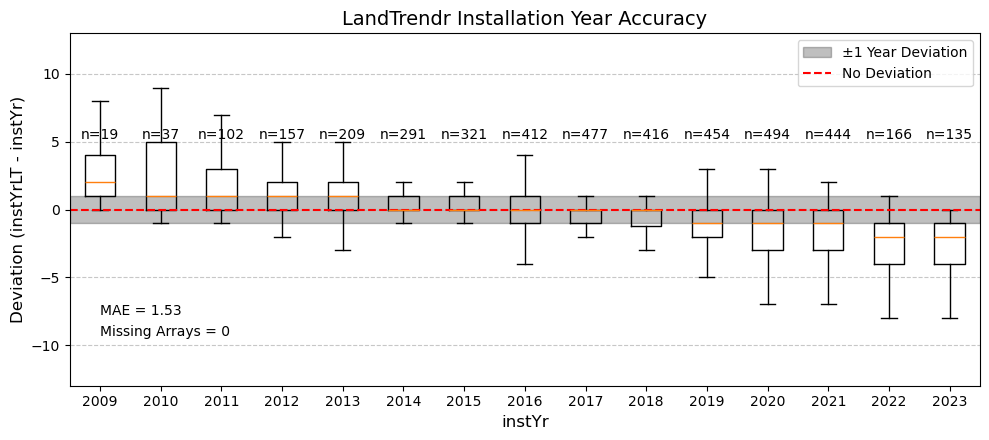

In [53]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Set plot df (Source 'USPVDB' or 'CCVPV')
plotdf = gmseusArrays[gmseusArrays['Source'].isin(['USPVDB'])]

# Calculate the deviation
plotdf['deviation'] = plotdf['instYrLT'] - plotdf['instYr']

# Remove any rows where instYrLT is -9999 or instYr is -9999
lt_data_noNull = plotdf[(plotdf['instYrLT'] != -9999) & (plotdf['instYr'] != -9999)]

# Drop rows where Source is anything other than USPVDB
lt_data_noNull = lt_data_noNull[lt_data_noNull['Source'] == 'USPVDB']

# Print the total number of arrays with a newly detected installation year
print('Number of arrays with a newly detected installation year:', lt_data_noNull['deviation'].value_counts().sum())

# Print the mean absolute deviation
print('Mean Absolute Error:', lt_data_noNull['deviation'].abs().mean())

# Create a list of deviation values grouped by instYr and count the number of data points in each group
data = [lt_data_noNull[lt_data_noNull['instYr'] == year]['deviation'] for year in range(2009, 2024)]
counts = [len(group) for group in data]

# Plot the boxplot without showing outliers
plt.figure(figsize=(10, 4.5))
# Add a shaded black (alpha = 0.25) that is plus or minus 1 year from the 0 line
plt.axhspan(-1, 1, color='black', alpha=0.25, label='±1 Year Deviation')

# Create the boxplot
plt.boxplot(data, positions=range(2009, 2024), widths=0.5, showfliers=False)

# Add the count (N) above each box
for i, count in enumerate(counts):
    plt.text(2009 + i, 5, f'n={count}', ha='center', va='bottom', fontsize=10)

# In the lower left corner, add the MAE and the difference between lt_data nrows with instYr and instYrLT values not equal to -9999 and source USPVDB, and the nrows of lt_data_noNull
plt.text(2009, -7, f'MAE = {lt_data_noNull["deviation"].abs().mean():.2f}', ha='left', va='top', fontsize=10)
plt.text(2009, -8.5, f'Missing Arrays = {plotdf[(plotdf['instYr'] != -9999) & (plotdf["Source"] == "USPVDB")].shape[0] - lt_data_noNull.shape[0]}', ha='left', va='top', fontsize=10)

# Set x and y limits
plt.xlim(2008.5, 2023.5)
plt.ylim(-13, 13)

# Add labels, title, and grid
plt.xlabel('instYr', fontsize=12)
plt.ylabel('Deviation (instYrLT - instYr)', fontsize=12)
plt.title('LandTrendr Installation Year Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a 0 line (no deviation)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='No Deviation')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Installed Capacity

In [48]:
# Call gmseusArrays and CCVPV arrays
#gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Print the number of CSP arrays
print('Number of CSP arrays:', gmseusArrays[gmseusArrays['modType'] == 'csp'].shape[0])

# Print the number of CSP arrays that are mount = single_axis
print('Number of CSP arrays that are single axis:', gmseusArrays[(gmseusArrays['modType'] == 'csp') & (gmseusArrays['mount'] == 'single_axis')].shape[0])

# Print mount type counts for CSP arrays
print('CSP Mount Type Counts:')
print(gmseusArrays[gmseusArrays['modType'] == 'csp']['mount'].value_counts())

Number of CSP arrays: 70
Number of CSP arrays that are single axis: 1
CSP Mount Type Counts:
mount
fixed_axis     33
dual_axis      14
mixed_df        7
mixed_ds        1
mixed_fs        1
single_axis     1
Name: count, dtype: int64


f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


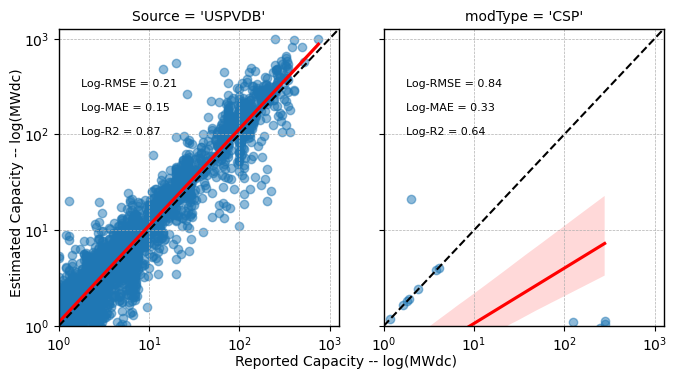

In [ ]:
# Call gmseusArrays and CCVPV arrays
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# First version of plotdf (Source = 'USPVDB')
plotdf1 = gmseusArrays[gmseusArrays['Source'].isin(['USPVDB'])]
plotdf1['capMW'] = np.log10(plotdf1['capMW'])
plotdf1['capMWest'] = np.log10(plotdf1['capMWest'])

# Second version of plotdf (modType = 'CSP')
plotdf2 = gmseusArrays[gmseusArrays['modType'] == 'csp']
plotdf2['capMW'] = np.log10(plotdf2['capMW'])
plotdf2['capMWest'] = np.log10(plotdf2['capMWest'])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate statistics and plot
fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=True, sharey=True)  # Side-by-side plots

# Function to plot regression plots with statistics
def regression_with_stats(ax, data, title):
    # Regression plot with confidence interval
    sns.regplot(x='capMW', y='capMWest', data=data, ax=ax, scatter_kws={'alpha': 0.5}, 
                line_kws={'color': 'red'}, ci=95)
    
    # 1:1 line
    ax.plot([0, 3.1], [0, 3.1], color='black', linestyle='--', label='1:1 Line')
    
    # Grid and styling
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Calculate statistics
    rmse = np.sqrt(((data['capMW'] - data['capMWest'])**2).mean())
    mae = (data['capMW'] - data['capMWest']).abs().mean()
    r2 = 1 - ((data['capMW'] - data['capMWest'])**2).sum() / ((data['capMW'] - data['capMW'].mean())**2).sum()
    
    # Add statistics text
    ax.text(0.25, 2.5, f'Log-RMSE = {rmse:.2f}', fontsize=8)
    ax.text(0.25, 2.25, f'Log-MAE = {mae:.2f}', fontsize=8)
    ax.text(0.25, 2.00, f'Log-R2 = {r2:.2f}', fontsize=8)
    
    # Axes limits and title
    ax.set_xlim(0, 3.1)
    ax.set_ylim(0, 3.1)
    ax.set_title(title, fontsize=10)
    
    # Log-scale ticks
    def log_tick_formatter(val, pos):
        return f"$10^{{{int(val)}}}$"

    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

    # Full box around the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)

    # Drop x and y titles
    ax.set_xlabel('')
    ax.set_ylabel('')

# Plot first dataframe
regression_with_stats(axes[0], plotdf1, "Source = 'USPVDB'")

# Plot second dataframe
regression_with_stats(axes[1], plotdf2, "modType = 'CSP'")

# Common axis labels
fig.text(0.5, 0.04, 'Reported Capacity -- log(MWdc)', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Estimated Capacity -- log(MWdc)', va='center', rotation='vertical', fontsize=10)

# Adjust layout and save
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(figure_path, 'capacityValidation_side_by_side.png'), dpi=300, bbox_inches='tight')
plt.show()

## Ground Cover Ratio

               GCR1    GCR2
mount                      
dual_axis    0.6155  0.6265
fixed_axis   0.5332  0.5572
mixed        0.4682  0.5430
single_axis  0.4308  0.5147
mount
fixed_axis     5479
mixed          1438
single_axis    1155
dual_axis       355
Name: count, dtype: int64
mount
fixed_axis     639
single_axis    360
Name: count, dtype: int64


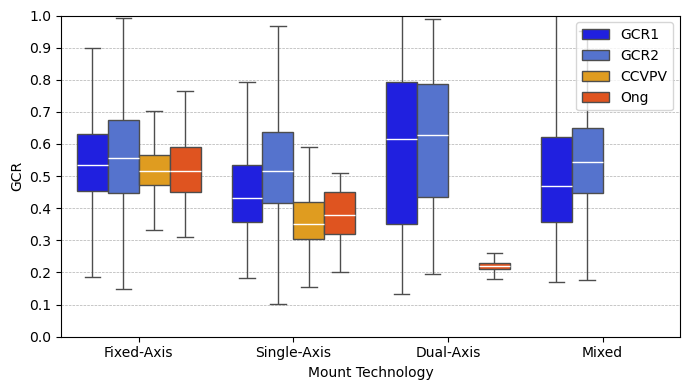

In [41]:
# ~~~~~~~~~~~~~~~~~~~~~~~ GMSEUS

# Call gmseusArrays and CCVPV arrays
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Select gmseusArrays where modType is not csp
#gmseusArrays = gmseusArrays[gmseusArrays['modType'] != 'csp']

# Subset for gmseusArrays where numRow > 0
gmseusArrays = gmseusArrays[gmseusArrays['numRow'] > 0]

# For the purpose of this plot, if mount contains "mixed_", set mount type as mixed
gmseusArrays.loc[gmseusArrays['mount'].str.contains('mixed_'), 'mount'] = 'mixed'

# Print median GCR1 and GCR2 values for each mount type
print(gmseusArrays.groupby('mount')[['GCR1', 'GCR2']].median())

# Melt GCR1 and GCR2 from gmseusArrays for plotting
gcr_melted = gmseusArrays.melt(
    id_vars='mount',
    value_vars=['GCR1', 'GCR2'],
    var_name='Dataset',
    value_name='Value')

# Print the number of arrays with each mount type
print(gmseusArrays['mount'].value_counts())

# ~~~~~~~~~~~~~~~~~~~~~~~ CCVPV

# Call ccvpvArrays
ccvpv = gpd.read_file(ccvpvInitArraysPath)

# Drop erronous PF values (< 0 and > 1)
ccvpv = ccvpv[(ccvpv['PF'] >= 0) & (ccvpv['PF'] <= 1)]

# Set a mount column. If Class is 'Si_Fixed_S', set to fixed_axis. If Class is 'Si_Single_E/W', set to single_axis. 
ccvpv['mount'] = np.nan
ccvpv['mount'] = ccvpv['mount'].astype(object)
ccvpv.loc[ccvpv['Class'] == 'Si_Fixed_S', 'mount'] = 'fixed_axis'
ccvpv.loc[ccvpv['Class'] == 'Si_Single_E/W', 'mount'] = 'single_axis'

# Melt PF values from ccvpvArrays for plotting
ccvpv_melted = ccvpv.melt(
    id_vars='mount',
    value_vars=['PF'],
    var_name='Dataset',
    value_name='Value'
)

# Update the Dataset column to label PF data
ccvpv_melted['Dataset'] = 'CCVPV'

# Print the number of arrays with each mount type
print(ccvpv['mount'].value_counts())

# ~~~~~~~~~~~~~~~~~~~~~~~ Ong et al., 2013

# Define the Ong et al., 2013 boxplot statistics
ong_data = {
    'mount': ['fixed_axis', 'single_axis', 'dual_axis'],
    'Min': [0.31, 0.20, 0.13],
    'Q1': [0.45, 0.32, 0.21],
    'Median': [0.51, 0.36, 0.22],
    'Q3': [0.59, 0.45, 0.23],
    'Max': [0.92, 0.51, 0.32]}
ong_df = pd.DataFrame(ong_data)

# Function to generate synthetic data based on boxplot statistics
def generate_synthetic_data(row, size=100):
    min_val, q1, median, q3, max_val = row['Min'], row['Q1'], row['Median'], row['Q3'], row['Max']
    lower_whisker = np.random.uniform(min_val, q1, size // 4)  # Values between Min and Q1
    iqr = np.random.uniform(q1, q3, size // 2)                # Values between Q1 and Q3
    upper_whisker = np.random.uniform(q3, max_val, size // 4) # Values between Q3 and Max
    return np.concatenate([lower_whisker, iqr, upper_whisker])

# Generate synthetic data for each mount type in Ong's dataset
synthetic_ong_data = []
for _, row in ong_df.iterrows():
    data = generate_synthetic_data(row)
    synthetic_ong_data.append(pd.DataFrame({
        'mount': row['mount'],
        'Value': data,
        'Dataset': 'Ong'}))

# Combine synthetic Ong data into a single DataFrame
synthetic_ong_df = pd.concat(synthetic_ong_data, ignore_index=True)

# ~~~~~~~~~~~~~~~~~~~~~~~ Plotting

# Combine the GMSEUS, CCVPV, and Ong et al., 2013 data
combined_df = pd.concat([gcr_melted, ccvpv_melted, synthetic_ong_df], ignore_index=True)

# Plot the combined dataset. Change x-axis names to 'Fixed-Axis', 'Single-Axis', and 'Dual-Axis'.
# Set dataset colors (GCR1: greyblue, GCR2: lightblue, CCVPV: orange, Ong: red). Make boxplot median a white line
plt.figure(figsize=(7, 4))
sns.boxplot(
    x='mount',
    y='Value',
    hue='Dataset',
    data=combined_df,
    palette={'GCR1': 'blue', 'GCR2': 'royalblue', 'CCVPV': 'orange', 'Ong': 'orangered'},
    showfliers=False,
    order=['fixed_axis', 'single_axis', 'dual_axis', 'mixed'], 
    medianprops={'color': 'white'})

# Set x-axis names
plt.xticks(ticks=[0, 1, 2, 3], labels=['Fixed-Axis', 'Single-Axis', 'Dual-Axis', 'Mixed'])

# Set y-axis limits
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))  # Set ticks from 0 to 1 in steps of 0.1

# Add title and labels
plt.xlabel('Mount Technology')
plt.ylabel('GCR')
plt.legend(loc='upper right')

# Add horizontal grid lines
plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
#plt.show()

# Save the plot
plt.savefig(os.path.join(figure_path, 'GCRValidation.png'), dpi=300)